# Filters
A notebook to test filter implementation for ease of converting to `C`, `C++`, or `ino` for the Arduino.

## Initial setup

In [1]:
import numpy as np
import math
from scipy.optimize import broyden1
from scipy.optimize.nonlin import NoConvergence
import matplotlib.pyplot as plt

In [2]:
cmap = plt.get_cmap('bone')

## Real-time peak detection (with drifting baseline)

### Create noisy signal
A quick explanation of the signal-to-noise ratio (SNR). The power for any waveform $y(t)$ over the interval $[0, T)$ is given by:

$
\quad P_y = \frac{1}{T} \int_0^T y^2(t) dt
$

The SNR is defined as the ratio of the signal ($s(t)$) power to the noise $N(t)$ power. If we assume that, over a given interval $[0, T)$:

- The signal is constant (non-random); that is, $s(t) = k \forall t \in [0, T)$.
- The noise is distributed as $\mathcal{N} (0, \sigma_N^2)$.

then the SNR becomes:

$
\begin{align}
\quad P_s 
&= \frac{1}{T} \int_0^T s^2(t) dt \\
&= \frac{1}{T} \int_0^T k^2 dt \\
&= \frac{1}{T} k^2 \int_0^T dt \\
&= \frac{1}{T} k^2 T \\
&= k^2
\end{align}
$

$
\begin{align}
\quad P_N 
&= \frac{1}{T} \int_0^T N^2(t) dt \\
&= \frac{1}{T} \int_0^T \left ( N(t) - 0 \right )^2 dt \\
&= \frac{1}{T} \int_0^T \left ( N(t) - \mathbb{E} \left [ N(t) \right ] \right )^2 dt \\
&= \sigma_N^2
\end{align}
$

$
\quad SNR = \dfrac{P_s}{P_N} = \dfrac{k^2}{\sigma_N^2}
$

or expressed in decibels:

$
\quad SNR_{dB} = 10 log_{10} \left ( \dfrac{P_s}{P_N} \right ) = 10 log_{10} \left ( \dfrac{k^2}{\sigma_N^2} \right )
$

[See here](http://www.scholarpedia.org/article/Signal-to-noise_ratio) for more details.

In [4]:
# Raw signal
T = 1000
y = np.zeros(T)

# Add noise (assume N(0, sigma_N))
sigma_N = 1.0
y += np.random.normal(loc=0.0, scale=sigma_N, size=T)

# Add peaks (assume N(SNR, 0))
SNR = 20.0 # dB
dt_signal = 5
n_signal = 10
t_signal = np.random.randint(int(0.10*T), int(min(0.9*T, T-dt_signal)), size=n_signal)
t_signal = (t_signal[:, np.newaxis] + (np.arange(dt_signal)+1)[np.newaxis, :]).flatten()
y[t_signal] += ((sigma_N**2)*(10**(SNR/10.0)))**0.5 # k = (sigma_N^2 10^(SNR_dB/10))^0.5

# Add constant drift
drift_slope = 0.01
y += np.arange(T)*drift_slope

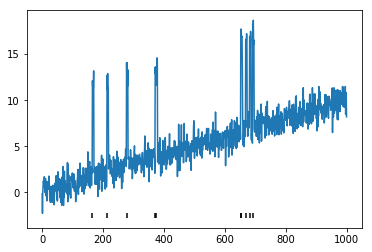

In [4]:
# Plot noisy signal
plt.plot(y)
plt.vlines(t_signal[::dt_signal], ymin=np.min(y)-0.5, ymax=np.min(y))

### Apply real-time filter
Since we are mimicking real-time, we will feed values one at a time. We will also keep in mind that we need to adapt this code to `C`, so we can't get too fancy with indexing or higher-level structures, nor do we want to store any data beyond the buffer size (in the actual implementation). 

Credit: https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data

In [97]:
# Filter settings
n_filt = 50 # length of filter
thresh = 4.0 # number of stds from mean
alpha = 0.0 # influence of datapoint containing signal on buffer

# Initialize buffers
buffer = np.zeros(n_filt)
buffer[:] = y[:n_filt]
buffer_mean = np.mean(buffer)
buffer_std = np.std(buffer)
p = 0 # buffer pointer

# Placeholder (for dev purposes)
y_filt_mean = np.zeros(T) # moving average
y_filt_mean[:n_filt] = buffer_mean
y_filt_std = np.zeros(T)
y_filt_std[:n_filt] = buffer_std
x = np.zeros(T) # signal

# Feed data stream
for t in range(n_filt, T):
    # Get buffer pointer
    p = t % n_filt
    
    # Check if signal threshold passed
    if abs(y[t] - buffer_mean) > thresh*buffer_std:
        # Update signal array
        if (y[t] - buffer_mean) > 0: # positive signal
            x[t] = 1.0
        else: # negative signal
            x[t] = -1.0
            
        # Update buffer
        buffer[p] = alpha*y[t] + (1.0 - alpha)*buffer[p-1]
    else:
        # Update signal and buffer
        x[t] = 0.0
        buffer[p] = y[t]
    
    # Update buffer stats
    buffer_mean = np.mean(buffer)
    buffer_std = np.std(buffer)
    
    # Update filtered data stream (dev)
    y_filt_mean[t] = buffer_mean
    y_filt_std[t] = buffer_std

true positive rate:  0.88 (44 of 50)
false positive rate: 0.00 (0 of 950)
false negative rate: 0.00 (0 of 50)


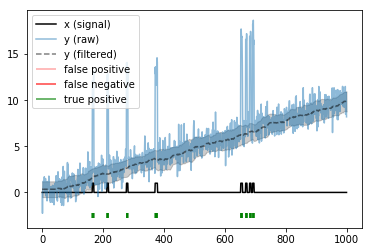

In [98]:
# Plot results
plt.plot(x, color='black', alpha=1.0, linestyle='-', label='x (signal)')
plt.plot(y, color='C0', alpha=0.5, linestyle='-', label='y (raw)')
plt.plot(y_filt_mean, color='black', alpha=0.50, linestyle='--', label='y (filtered)')
plt.fill_between(np.arange(T), y1=y_filt_mean-y_filt_std, y2=y_filt_mean+y_filt_std,
                 color='black', alpha=0.2)

# Plot ground truth
idx_gt = np.zeros(T, dtype=np.bool)
idx_gt[t_signal] = True
idx_tp = np.logical_and(x == 1.0, idx_gt)
idx_fp = np.logical_and(np.abs(x) == 1.0, ~idx_gt)
idx_fn = np.logical_and(x == 0.0, idx_gt)
plt.vlines(np.argwhere(idx_fp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.35, color='red', label='false positive')
plt.vlines(np.argwhere(idx_fn).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='red', label='false negative')
plt.vlines(np.argwhere(idx_tp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='green', label='true positive')

# Show legend
plt.legend()

# Print results
print('true positive rate:  %.2f (%d of %d)' % (np.sum(idx_tp)/(n_signal*dt_signal), np.sum(idx_tp), n_signal*dt_signal))
print('false positive rate: %.2f (%d of %d)' % (np.sum(idx_fp)/(T - n_signal*dt_signal), np.sum(idx_fp), T - n_signal*dt_signal))
print('false negative rate: %.2f (%d of %d)' % (np.sum(idx_fn)/(n_signal*dt_signal), np.sum(idx_fn), n_signal*dt_signal))

### Save filter

In [8]:
np.savetxt('testFilterData.txt', y)

### Check update functions
Rather than recalculating the new mean and standard deviation of the buffer every iteration, let's try updating the statistics based on the previous values.

In [90]:
# Filter settings
n_filt = 50 # length of filter
thresh = 3.0 # number of stds from mean
alpha = 0.0 # influence of datapoint containing signal on buffer

# Initialize buffers
buffer = np.zeros(n_filt)
buffer[:] = y[:n_filt]
buffer_mean = np.mean(buffer)
buffer_std = np.std(buffer)
p = 0 # buffer pointer

# Placeholder (for dev purposes)
y_filt_mean = np.zeros(T) # moving average
y_filt_mean[:n_filt] = buffer_mean
y_filt_std = np.zeros(T)
y_filt_std[:n_filt] = buffer_std
x = np.zeros(T) # signal

# New method placeholders
y_filt_mean_ = np.zeros(T) # moving average
y_filt_mean_[:n_filt] = buffer_mean
y_filt_std_ = np.zeros(T)
y_filt_std_[:n_filt] = buffer_std
N = n_filt

# Feed data stream
for t in range(n_filt, T):
    # Get buffer pointer
    p = t % n_filt
    
    # Cache
    buffer_old = buffer[p]
    
    # Check if signal threshold passed
    if abs(y[t] - buffer_mean) > thresh*buffer_std:
        # Update signal array
        if (y[t] - buffer_mean) > 0: # positive signal
            x[t] = 1.0
        else: # negative signal
            x[t] = -1.0
            
        # Update buffer
        buffer[p] = alpha*y[t] + (1.0 - alpha)*buffer[p-1]
    else:
        # Update signal and buffer
        x[t] = 0.0
        buffer[p] = y[t]
    
    # Update buffer stats (old method)
    buffer_mean = np.mean(buffer)
    buffer_std = np.std(buffer)
    
    # Update buffers stats (new method)
    y_filt_mean_[t] = y_filt_mean_[t-1] + (1/N)*(buffer[p] - buffer_old)
    dmean = (1/N)*(buffer[p] - buffer_old)
    y_filt_std_[t] = (y_filt_std_[t-1]**2 - (1/N)*(buffer_old - y_filt_mean_[t-1])**2 + (1/N)*(buffer[p] - y_filt_mean_[t])**2
                      + (2*dmean/N)*(buffer_old - y_filt_mean_[t-1]) + ((N-1)/N)*(dmean**2))**0.5
    
    # Update filtered data stream (dev)
    y_filt_mean[t] = buffer_mean
    y_filt_std[t] = buffer_std

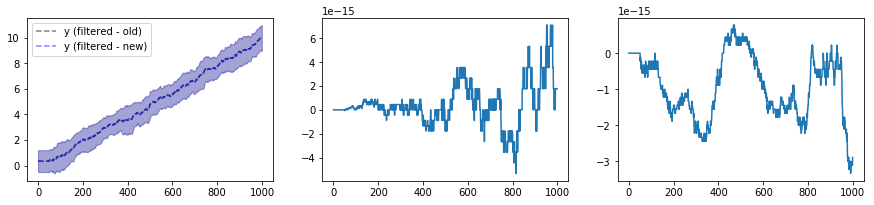

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

# Plot results
ax[0].plot(y_filt_mean, color='black', alpha=0.50, linestyle='--', label='y (filtered) (old)')
ax[0].fill_between(np.arange(T), y1=y_filt_mean-y_filt_std, y2=y_filt_mean+y_filt_std,
                 color='black', alpha=0.2)
ax[0].plot(y_filt_mean_, color='blue', alpha=0.50, linestyle='--', label='y (filtered) (new)')
ax[0].fill_between(np.arange(T), y1=y_filt_mean_-y_filt_std_, y2=y_filt_mean_+y_filt_std_,
                 color='blue', alpha=0.2)
ax[0].legend()

# Plot differences
ax[1].plot(y_filt_mean - y_filt_mean_)
ax[2].plot(y_filt_std - y_filt_std_)

Pretty accurate with some drifting over time. It looks like a nice compromise would be to recalculate the ground truth mean and standard deviation every so many iterations to zero out the drift occasionally.

### c++ implementation

In [2]:
y_cpp = np.loadtxt('../data/testFilterData.txt')
x_cpp = np.loadtxt('../data/signal.txt')

true positive rate:  0.00 (0 of 50)
false positive rate: 0.05 (44 of 950)
false negative rate: 0.94 (47 of 50)


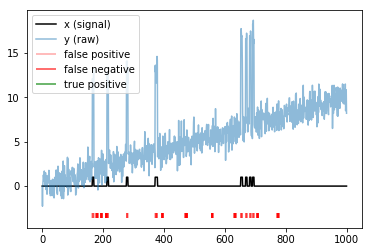

In [5]:
# Plot results
plt.plot(x_cpp, color='black', alpha=1.0, linestyle='-', label='x (signal)')
plt.plot(y_cpp, color='C0', alpha=0.5, linestyle='-', label='y (raw)')

# Plot ground truth
idx_gt = np.zeros(T, dtype=np.bool)
idx_gt[t_signal] = True
idx_tp = np.logical_and(x_cpp == 1.0, idx_gt)
idx_fp = np.logical_and(np.abs(x_cpp) == 1.0, ~idx_gt)
idx_fn = np.logical_and(x_cpp == 0.0, idx_gt)
plt.vlines(np.argwhere(idx_fp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.35, color='red', label='false positive')
plt.vlines(np.argwhere(idx_fn).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='red', label='false negative')
plt.vlines(np.argwhere(idx_tp).flatten(), ymin=np.min(y)-0.5, ymax=np.min(y), 
           alpha=0.75, color='green', label='true positive')

# Show legend
plt.legend()

# Print results
print('true positive rate:  %.2f (%d of %d)' % (np.sum(idx_tp)/(n_signal*dt_signal), np.sum(idx_tp), n_signal*dt_signal))
print('false positive rate: %.2f (%d of %d)' % (np.sum(idx_fp)/(T - n_signal*dt_signal), np.sum(idx_fp), T - n_signal*dt_signal))
print('false negative rate: %.2f (%d of %d)' % (np.sum(idx_fn)/(n_signal*dt_signal), np.sum(idx_fn), n_signal*dt_signal))

### Arduino implementation
The limited Arduino processor imposes a trade-off between buffer size (which increases time to update the filter) and sampling rate (which sets the minimum sampling period and thus filter update frequency). That is, the longer the buffer, the slower the sampling rate must be; otherwise, the time to update the buffer will exceed the sampling rate, leading to unintended slow buffers that lag in real-time (e.g. fill every 5 seconds instead of every second). 

NOTE: The following data was acquired using an Arduino MEGA 2560.

EDIT: This only applies to naive buffer statistics calculations. If one-sample updates are used instead, then filter calculations take roughly constant time (see below):

| buffer size<sup>a</sup> (n) | sensitivity (a.u.) | time per iteration, one sensor (us) | time per iteration, two sensors (us) |
| --------------- | --------------- | ----------------------- | ----------------------- |
| 0<sup>b</sup> | - | 500 | 500 |
| 0<sup>c</sup>  | 30 | 1500 | 3300 | 
| <i></i> | 60 | 3900 | 8800 |
| <i></i> |120 | 7500 | 17300 |
|  1-1500<sup>d</sup>  | 30 | 2000 | 4300 |
|  <i></i>  | 60 | 4400 | 9700 |
|  <i></i>  | 120 | 8000 | 18200 |
|  2000+ | 30 | memory overflow | memory overflow |
|  <i></i> | 60 | memory overflow | memory overflow |
|  <i></i> | 120 | memory overflow | memory overflow |

a. The *total* number of elements across all filters (e.g. one filter with a buffer size of 1000, or two buffers with a size of 500 each)

b. only `time` and `Serial.print()` functions

c. above plus `CapacitiveSensor(sensitivity)`

d. above plus `MovingFilter` of type `long`

Although not perfect, we will roughly assume a linear relationship of the above constraints, leading to the following guidelines:

$
\quad sampleRate \leq \dfrac{500}{(nSensors)(\frac{sensitivity}{30})} \\
\quad tFilter \leq \dfrac{1500}{(nSensors)(sampleRate)}
$

### Parameter settings
Finding the right parameter space for the filter can be tricky. Let's take a look at some different considerations.

#### On-off time
A nice feature of this filter is that it will automatically turn the signal off if a new baseline is reached (e.g. a wire touches something nearby, or a drop of water stays on the spout). What is the time to setting the new baseline and thereby turning off the signal?

Let's say the original baseline is drawn from $y_t \sim \mathcal{N}(y, \sigma)$ and that new baseline suddenly becomes $y'_t \sim \mathcal{N}(y', \sigma')$, where $y' = y + k$, and $k > \gamma \sigma$. Therefore, the filter recognizes the incoming data stream as a signal, and applies the filter accordingly to update the buffer $\mathbf{x}$:

$
\quad x_t = \alpha y'_t + (1 - \alpha) x_{t-1}
$

In order to ensure detection of the shift in baseline, the set of parameters $\beta = 1 - \alpha$, $\gamma$, and buffer size $n$ must satisfy the following inequality:

$
\gamma^2 - \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )} \geq 0
$

Derivation of this inequality is shown in the Appendix below.

Let's plot some examples:

In [3]:
def sum_x_exp(alpha, t, n, exp=1):
    base = (1.0-alpha)*np.ones(n)
    exp = exp*np.arange(t-n+1, t+1)
    exp[exp < 0] = 0
    return np.sum(np.power(base, exp))

def get_off_time(alpha=None, n=None, gamma=None):
    def _make_array(a):
        if not isinstance(a, np.ndarray):
            return np.array([a])
        else:
            return a

    # Check parameters
    if sum([p is None for p in [alpha, n, gamma]]) > 1:
        raise ValueError('Too many unknowns.')
    elif sum([p is None for p in [alpha, n, gamma]]) == 0:
        raise ValueError('No unknowns to solve.')
        
    # Solve for gamma
    elif gamma is None:
        # Make array form
        n = _make_array(n)
        alpha = _make_array(alpha)
        if (alpha >= 1.0).any() or (alpha <= 0.0).any():
            raise ValueError('alpha must be between 0.0 and 1.0')
        
        # Summation form
        #sum_x_1 = sum_x_exp(alpha, t, n, exp=1)
        #sum_x_2 = sum_x_exp(alpha, t, n, exp=2)
        #return (n*sum_x_2/sum_x_1**2 - 1.0)**-0.5
        
        # No summation form
        beta = 1.0 - alpha
        num = (1.0 - beta**(-n))**2 * (beta + 1)
        den = n*(1.0- beta**(-2*n))*(beta - 1) - num
        return (num / den)**0.5
        
    # Solve for n
    elif n is None:
        # Make array form
        gamma = _make_array(gamma)
        alpha = _make_array(alpha)
        if (alpha >= 1.0).any() or (alpha <= 0.0).any():
            raise ValueError('alpha must be between 0.0 and 1.0')
        
        # Define zero equation
        beta = 1.0 - alpha
        def F(n):
            num = (1.0 - beta**(-n))**2 * (beta + 1)
            den = n*(1.0 - beta**(-2*n))*(beta - 1) - num
            return gamma**2 - (num/den) 
        
        # Initial value is important since curvature is very flat
        # far from solution, leading to NoConvergence unless initial guess
        # is reasonable. Try over range of initial values.
        x_inits = [1.0001, 1.1, 5, 25, 125]
        for x_init in x_inits:
            try:
                # Attempt to solve with x_init. 
                # Because equation is even (f(x) = f(-x); see Appendix),
                # we can return absolute value of either solution
                x_init = x_init*np.ones(gamma.shape)
                return np.abs(broyden1(F, x_init))
            
            except (NoConvergence, FloatingPointError):
                continue
        
        return np.full(gamma.shape, np.nan)
    
    elif alpha is None:
        # Make array form
        n = _make_array(n)
        gamma = _make_array(gamma)
        
        # Define zero equation
        def F(beta):
            num = (1.0 - beta**(-n))**2 * (beta + 1)
            den = n*(1.0 - beta**(-2*n))*(beta - 1) - num
            return gamma**2 - (num/den) 
        
        # Initial value is important since curvature is very flat
        # far from solution, leading to NoConvergence unless initial guess
        # is reasonable. Try over range of initial values.
        odd_failure = False
        x_inits = np.logspace(-5, -0.1, 100)
        for x_init in x_inits:
            try:
                # Attempt to solve with x_init. 
                x_init = x_init*np.ones(gamma.shape)
                alpha_soln = np.ones(gamma.shape) - broyden1(F, 1.0 - x_init)
                
                # Even n values create an even equation, so
                # positive or negative solution acceptable
                idx = (n % 2 == 0)
                alpha_soln[idx] = np.abs(alpha_soln[idx])
                
                # Odd values do not create either even or odd equation,
                # so must be thrown out
                if (alpha_soln[~idx] < 0.0).any():
                    odd_failure = True
                    continue
                
                return alpha_soln
            
            except (NoConvergence, FloatingPointError):
                continue
        
        if odd_failure:
            print('Failed to find solution due to odd n values. Try entering '
                  'only even values instead.')
        return np.full(gamma.shape, np.nan)
        
def buffer_mean(alpha, t, n, k):
    return k - (k/n)*sum_x_exp(alpha, t, n, exp=1)

def buffer_std(alpha, t, n, k):
    return (k/n)*(n*sum_x_exp(alpha, t, n, exp=2) - (sum_x_exp(alpha, t, n, exp=1))**2)**0.5

k: 100.00
n: 10
alpha: 0.10
gamma: 3.34


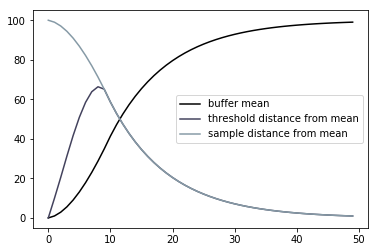

In [4]:
alpha = 0.1
n = 10
k = 100
t = np.arange(0, 5*n)
gamma = get_off_time(alpha=alpha, n=n)
mean = np.zeros(t.size)
std = np.zeros(t.size)
for i, t_i in enumerate(t):
    mean[i] = buffer_mean(alpha, t_i, n, k)
    std[i] = buffer_std(alpha, t_i, n, k)
    
fig, ax = plt.subplots()
plt.plot(t, mean, 
         label='buffer mean',
         color=cmap(0.0))
plt.plot(t, std*gamma, 
         label='threshold distance from mean', 
         color=cmap(0.3))
plt.plot(t, k - mean, 
         label='sample distance from mean',
         color=cmap(0.6))
plt.legend()

print('k: %.2f' % k)
print('n: %d' % n)
print('alpha: %.2f' % alpha)
print('gamma: %.2f' % gamma)

From the plot above, we can see why we lose $t$ dependence in the inequality that governs parameter relationships. Once the buffer has been completely filled with samples from the signal, both the sample distance from the mean, $y'_t - \mu_t$, and the threshold distance from the mean, $\gamma \sigma_t$, decay exponentially. Thus they will either overlap exactly, or never at all, though their difference will approach zero over time. Of course, in reality $\sigma' \neq 0$, so any one sample could trigger the off-time. A more realistic constraint would be to specify that the mean sample distance from mean is within some distance $\epsilon$ from the threshold:

$
\quad y'_t  - \mu_t \leq \gamma \sigma_t \\
\quad \Rightarrow (y' - \epsilon) - \mu_t \leq \gamma \sigma_t \\
\quad \Rightarrow y + k - \mu_t \leq \gamma \sigma_t + \epsilon
$

so that a sample drawn from $\mathcal{N}(y', \sigma')$ within $\epsilon$ of the buffer threshold will trigger the signal to off.

This would lead to an additional term in the inequality that is dependent on $t$:

$
\gamma^2 - \left ( \sqrt{\dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )}} - \dfrac{\epsilon}{\dfrac{k}{n}\sqrt{n \sum_{i=t-n+1}^{t} \beta^{2i} - \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}} \right )^2 \geq 0
$

since the denominator of the expression with $\epsilon$ no longer has a $\beta^{2t}$ term to cancel out in the numerator. To solve for $t$, we would first need to convert the summation to the exponential form (containing the $\beta^{2t}$ term) before passing the ever more complicated expression to a non-linear solver. For now, a story for another day :-)

Instead, we will focus on a solution that, on average, will trigger the signal off after one full run-through of the buffer. Let's look at a range of solutions in this constrained parameter space to get a sense of what we could potentially use for our implementation:

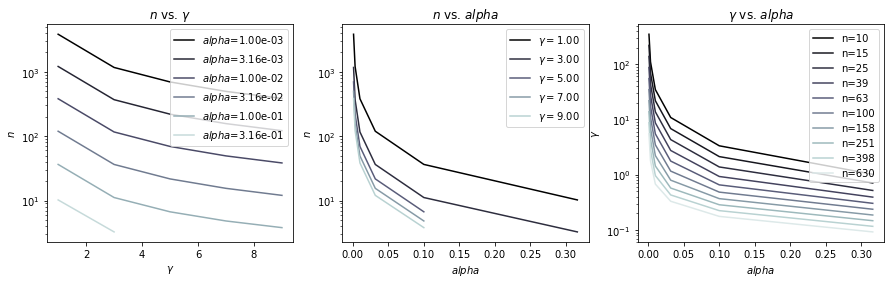

In [458]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Range to plot
alpha_range = [10**x for x in np.linspace(-3, 0, 7)[:-1]]
gamma_range = np.arange(1, 10, 2)
n_range = np.logspace(1, 2.8, 10)

# Find parameters solutions given constraints
n_soln = np.zeros([len(alpha_range), len(gamma_range)])
gamma_soln = np.zeros([len(alpha_range), len(n_range)])
for i, alpha in enumerate(alpha_range):
    for j, gamma in enumerate(gamma_range):
        n_soln[i, j] = get_off_time(alpha, gamma=gamma)
    for k, n in enumerate(n_range):
        gamma_soln[i, k] = get_off_time(alpha, n=n)
            
# Plot n vs. gamma for fixed alpha
for i, alpha in enumerate(alpha_range):
    ax[0].plot(gamma_range, n_soln[i, :], 
               label='$alpha$=%.2e' % alpha,
               color=cmap(i/len(alpha_range)))
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel('$\gamma$')
ax[0].set_ylabel('$n$')
ax[0].set_title('$n$ vs. $\gamma$')

# Plot n vs. alpha for fixed gamma
for j, gamma in enumerate(gamma_range):
    ax[1].plot(alpha_range, n_soln[:, j], 
               label='$\gamma=%.2f$' % gamma,
               color=cmap(j/len(gamma_range)))
ax[1].legend()
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$alpha$')
ax[1].set_ylabel('$n$')
ax[1].set_title('$n$ vs. $alpha$')

# Plot alpha vs. gamma for fixed n
for k, n in enumerate(n_range):
    ax[2].plot(alpha_range, gamma_soln[:, k], 
               label='n=%d' % n,
               color=cmap(k/len(n_range)))
ax[2].legend()
#ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlabel('$alpha$')
ax[2].set_ylabel('$\gamma$')
ax[2].set_title('$\gamma$ vs. $alpha$');

Now that we have an idea of the range we're working with, let's find an exact solution given some constraints. We know that:

1. $n \geq 100$ to buffer noise appropriately
2. $n \leq 1500$ due to Arduino memory constraints
3. $\gamma \geq 3.0$ to limit false positives
4. $\gamma \leq 5.0$ to limit false negatives

Looking at the above graphs, it's clear that $\alpha$ needs to be small from the $\gamma$ vs. $\alpha$ plot given that we want a decent buffer size $n$. I will choose $n = 100$ and $\gamma = 5.0$.

In [9]:
# Find specific solution
n = 100
gamma = 5.0
alpha = get_off_time(n=n, gamma=gamma)

print('Parameters: n=%d, gamma=%.2f, alpha=%.5f' % (n, gamma, alpha))

Parameters: n=100, gamma=5.00, alpha=0.00693


## Experimental analysis
The above tests were conducted using the z-score of the current value for signal detection. While useful for many applications, the nature of the capacitive sensor data (large, rapid deviations from mean) is not as conducive for this method. Instead, we can simply put a hard threshold on the value for signal detection (i.e. signal if value > threshold, otherwise no signal) while still incorporating our moving average filter to determine the deviation from baseline. Let's compare these two methods of signal thresholding with data collected during an experiment from two lick sensors running `capacitiveSensorVariable/capacitiveSensorVariable.ino`, which uses the built-in baseline heuristic found in `CapacitiveSensor::capacitiveSensor()` as opposed to `CapacitiveSensor::capacitiveSensorRaw()`. The `CapacitiveSensor` library was modulated to output debugging values, such as the timestamp, raw value, and estimated baseline, every method call.

### Load and preprocess data

In [3]:
# Load sensor (analog) data
filelist = ['../data/experimental/W2313_05-20-21_raw1.txt',
            '../data/experimental/W2313_05-20-21_raw2.txt']
data = []
for filename in filelist:
    data.append(np.loadtxt(filename, delimiter=' ', skiprows=1))
    
# Clock may reset during session, so correct time to be monotonic.
# This should only happen at most once.
t_data = []
for dat in data:
    t0 = dat[0, 0]
    t = (dat[:, 0] - t0)/1e6
    if np.argwhere(t[1:] < t[:-1]).any():
        idx_offset = np.argwhere(t[1:] < t[:-1]).squeeze()
        t_offset = t[idx_offset] - t[idx_offset+1]
        t[idx_offset+1:] += t_offset
    t_data.append(t)

In [4]:
# Load main IO board (digital) data
filelist = ['../data/experimental/W2313_05-20-21_lick1.txt',
            '../data/experimental/W2313_05-20-21_lick2.txt']
fs = 500 # sampling rate
lick = []
for filename in filelist:
    lick.append(np.loadtxt(filename, delimiter=' ', skiprows=1))
    
# Get lick times from digital data
t_delay = 10.0 # rough estimate of lag between sensor data and IO board
t_lick = []
for l in lick:
    thresh = np.max(l) / 2.0
    idx_licking = (l > thresh).astype(np.int32)
    idx_lick = (np.argwhere((idx_licking - np.roll(idx_licking, -1)) == -1) + 1).flatten()
    t_lick.append(idx_lick/fs + t_delay)

### Plot sensor data

<IPython.core.display.Javascript object>


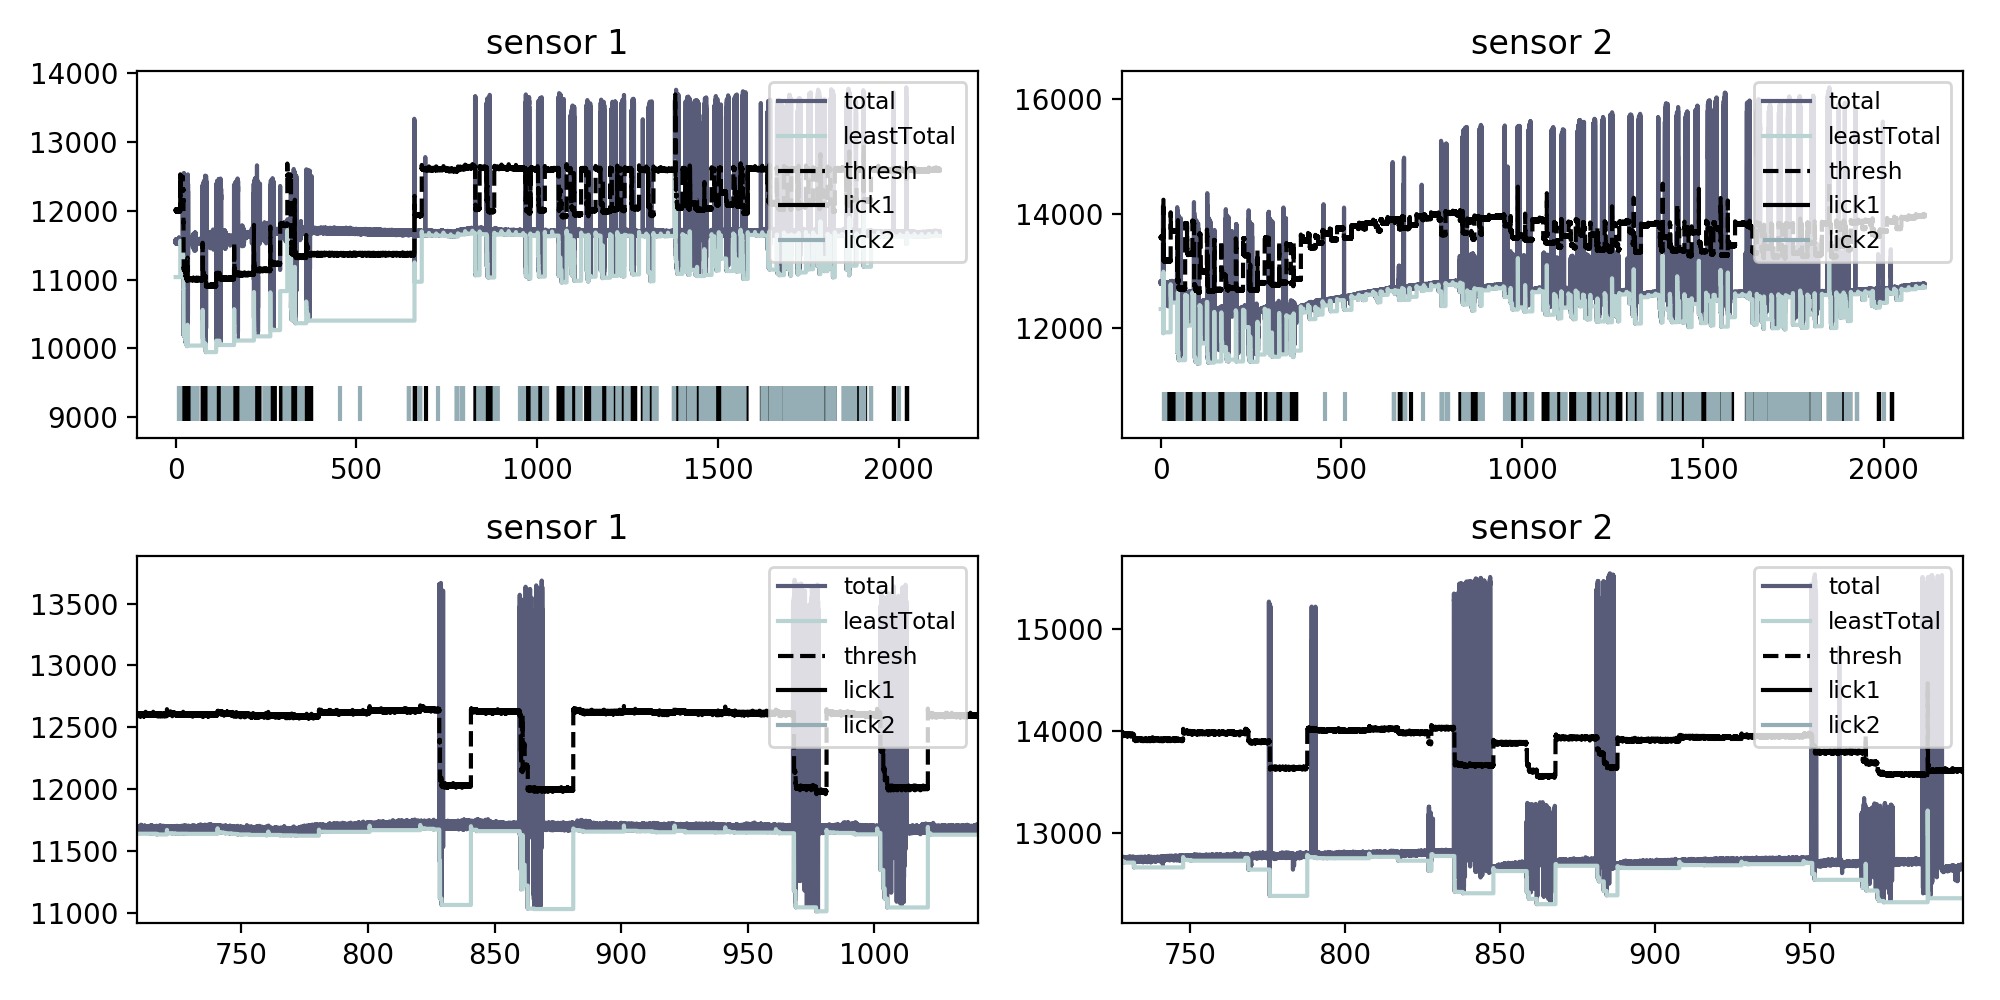

In [6]:
%matplotlib notebook
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
cmap = plt.get_cmap('bone')

# Plot digital signal as events
for i, dat in enumerate(data):
    
    # Exclude auto-calibrate samples (leastTotal = MAX_VALUE)
    idx = np.argwhere(data[i][:, 3] == 0)
    
    # Plot raw sensor values
    for j in range(2):
        ax_ = ax[j, i]
        ax_.plot(t_data[i][idx], data[i][idx, 1], 
                   color=cmap(0.4), label='total')
        ax_.plot(t_data[i][idx], data[i][idx, 2], 
                   color=cmap(0.8), label='leastTotal')
        ax_.plot(t_data[i][idx], data[i][idx, 5] + data[i][idx, 2], 
                   linestyle='--', color=cmap(0.0), label='thresh')
        ax_.set_title('sensor {}'.format(i+1));
    
    # Plot lick events
    ax_ = ax[0, i]
    for k, t in enumerate(t_lick):
        ymin = data[i][idx, 2].min() - 1000
        ax_.vlines(t, ymin=ymin, ymax=ymin+500, 
                     color=cmap(k/1.5), label='lick{}'.format(k+1))
    
    # Plot raw digital trace
    ax_ = ax[1, i]
    for k, l in enumerate(lick):
        t = np.arange(len(l))/fs + t_delay
        ymin = data[i][idx, 2].min() - 1000
        ymax = ymin + 500
        ax_.plot(t, l*(ymax - ymin) + ymin, color=cmap(k/1.5), label='lick{}'.format(k+1))
        
# Format axis
for ax_ in ax.flatten():
    ax_.legend(fontsize='small', loc='upper right');
    
plt.tight_layout();

Some takeaways from the above plots:
- Licking at the same sensor causes the sensor values to fluctuate dramatically both above and below true baseline, regardless of the other sensor's interaction. This alone can account for the drop in the estimated baseline value, which quickly grabs the lowest points of the waveform during licking. For example, see the first few lickbouts on sensor 1.
- Licking at the other sensor causes a less dramatic but still significant variation in the sensor values. Moreover, the direction of the fluctuations is complicated. For instance, the small upward spike at about 18 seconds on sensor 1 causes a small spike at sensor 2 in the *opposite* direction before a mostly downward fluctuation. However, two lickbouts at sensor 1 at ~825 and 860 seconds cause a primarly upward and then neutral fluctuation at sensor 2. This is probably a complex interaction of the output signal, the frequency and amplitude of the fluctuations, and the duration of the fluctuations.
- Lickbouts are probably the primary driver of this effect, compared to isolated licks. For example, view the isolated licks at times ~660 and 690 (sensor 1), and 450, 507, 543, 642, 672, and 721 (sensor 2). These have a much less profound effect, if at all, on the readings on the other sensor. This could be a result of the frequency of a lickbout, or the body positioning of animals when truly engaged in poking/licking, i.e. placing snout, whiskers, etc. sporadically on lickspout.
- Fluctuations from the other sensor are thankfully smaller in amplitude and should be able to be filtered out appropriately while maintaining an accurate threshold for sensing licks.

### Filter sensor data
Let's test some filters for the sensor data in order to better estimate the true baseline.

#### Moving average (FIR filter)
The moving average filter will consist of a buffer of size $m$, which is filled with the most recent sensor values taken every $k$ samples. Downsampling to a frequency of $f_b = \frac{f_s}{k}$ is a simple solution to minimizing the impact of signal values on the buffer statistics. Note, however, that we don't want to sacrifice our temporal resolution for the capturing the lick signal, which is why only the baseline is downsampled. Moreover, we probably could implement a rudimentary low-pass filter instead, but downsampling is a simple and effective solution, as shown below.

We have two parameters to explore: buffer size and sample frequency.

Note: Taking every sample ($k=1$) leads to a noisy baseline, which is not shown below.

In [6]:
import itertools

# Iterate through samples
base_ma = []
M = [100, 500, 1000] # length of filter
K = [10, 100] # update every k samples
for i, dat in enumerate(data):
    # Get raw values
    total = dat[:, 1]
    
    # Iterate over parameters
    base_ = []
    for m, k in itertools.product(M, K):
        base = np.zeros(total.shape)
        thresh = 0
        buf = np.zeros([m])
        p = 0
        for j in range(len(total)):
            # Update buffer
            if j % k == 0:
                if j < m*k: # filling buffer
                    thresh = total[j]
                    buf[p] = total[j]
                    p = (p + 1) % m
                elif (abs(total[j] - base[j-1]) < 0.1*base[j-1]): # no signal
                    buf[p] = total[j]
                    p = (p + 1) % m

            # Update baseline
            if j < m*k:
                base[j] = total[0]
            else:
                base[j] = buf.mean()
        
        base_.append(base)

    base_ma.append(base_)

<IPython.core.display.Javascript object>


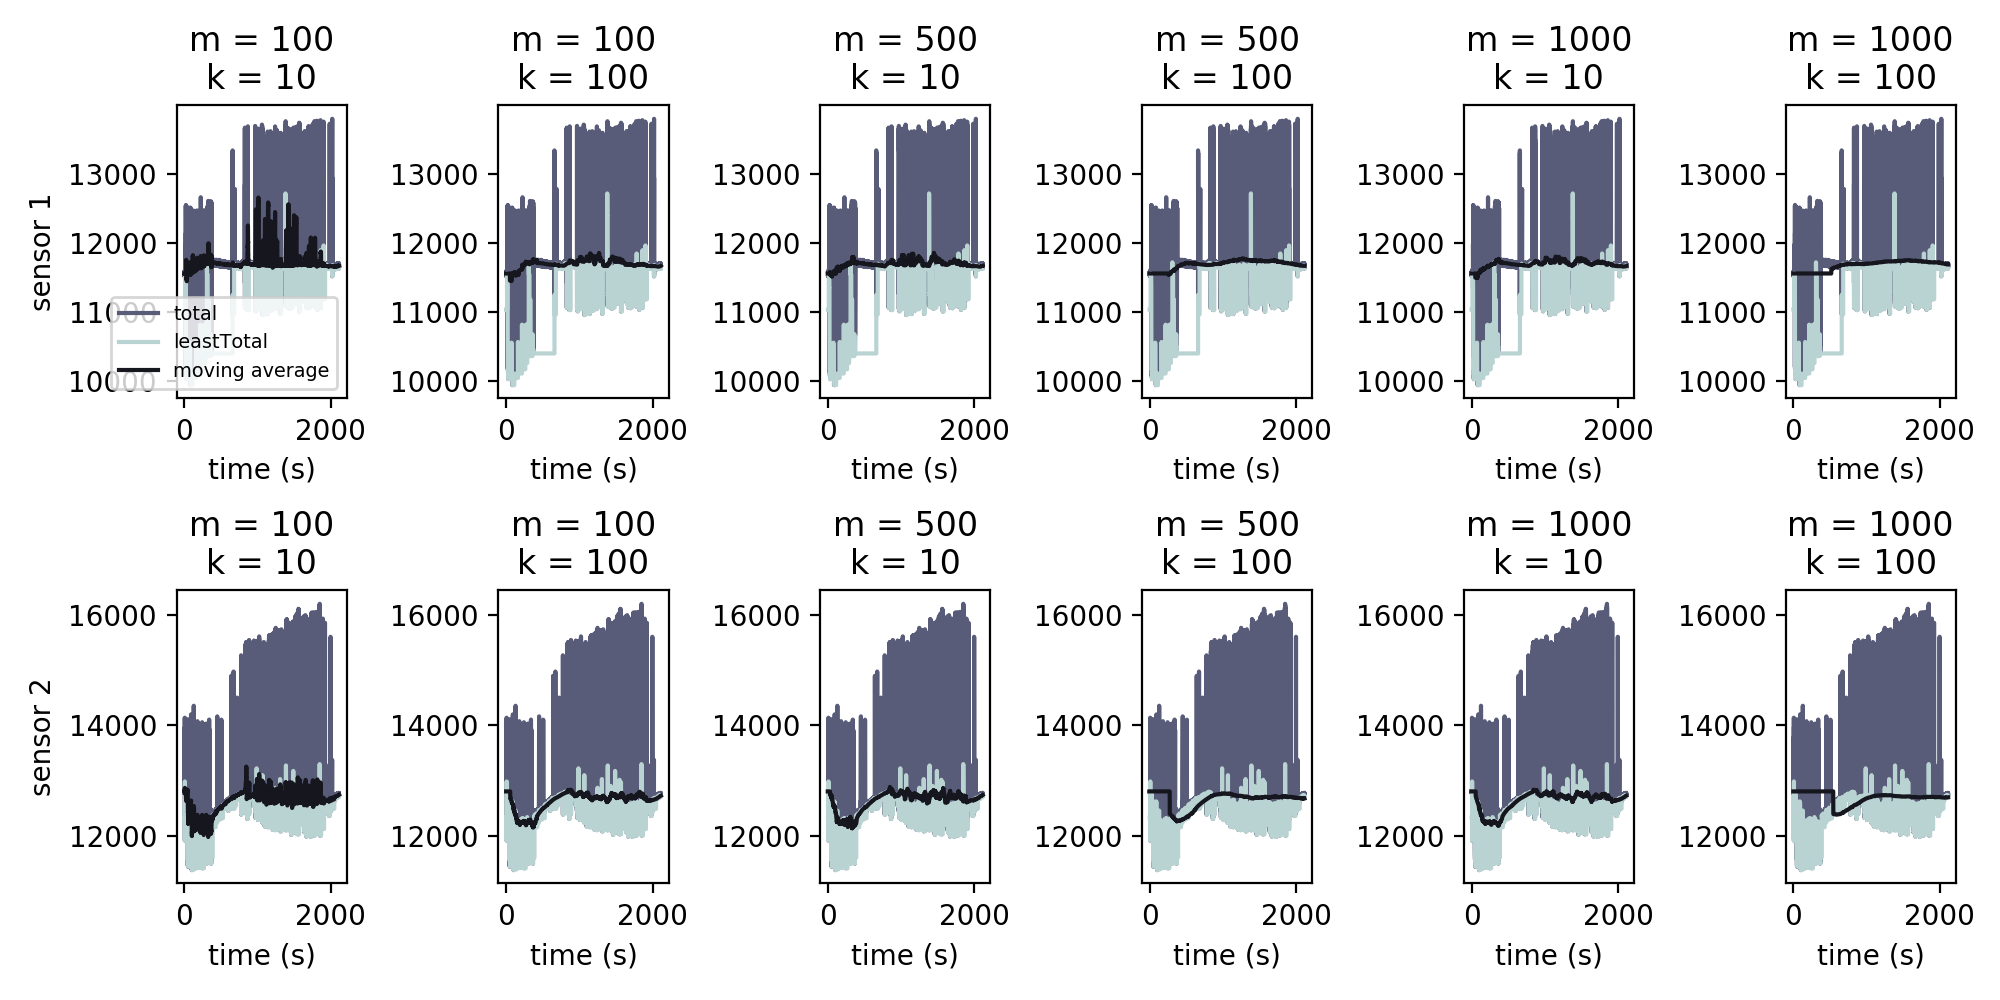

In [7]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=len(data), ncols=len(M)*len(K), figsize=(10, 5))
cmap = plt.get_cmap('bone')

for i, dat in enumerate(data):
    ax[i, 0].set_ylabel('sensor {}'.format(i+1))
    
    for j, (m, k) in enumerate(itertools.product(M, K)):
        ax_ = ax[i, j]
        
        # Exclude auto-calibrate samples (leastTotal = MAX_VALUE)
        idx = np.argwhere(dat[:, 3] == 0)
        
        # Plot values
        ax_.plot(t_data[i], dat[:, 1], color=cmap(0.4), label='total') # raw values
        ax_.plot(t_data[i][idx], dat[idx, 2], color=cmap(0.8), label='leastTotal') # original baseline estimate
        ax_.plot(t_data[i], base_ma[i][j], color=cmap(0.1), label='moving average') # MA baseline estimate
        
        # Format axis
        ax_.set_xlabel('time (s)')
        ax_.set_title('m = {}\nk = {}'.format(m, k))

ax[0, 0].legend(loc='lower right', fontsize='x-small');
plt.tight_layout();

In [8]:
# Estimate time resolution of parameter sets
dt_mean = np.hstack([np.diff(dt) for dt in t_data]).mean()
dt_std = np.hstack([np.diff(dt) for dt in t_data]).std()
fs_std = np.hstack([np.diff(1.0/dt[dt > 0]) for dt in t_data]).std()

print('sampling rate: {:.3f} +/- {:.3f}'.format(1.0/dt_mean, fs_std) )
print('sampling period: {:.3e} +/- {:.3e}\n'.format(dt_mean, dt_std))

for (m, k) in itertools.product(M, K):
    title = 'm = {}, k = {}'.format(m, k)
    print(title)
    print('-'*len(title))
    print('total duration: {:.3f} seconds'.format(m*k*dt_mean))
    print('sampling rate: {:.3f}'.format(1.0/(dt_mean*k)))
    print('sampling period: {:.3f}\n'.format(dt_mean*k))

sampling rate: 185.503 +/- 0.163
sampling period: 5.391e-03 +/- 2.550e-04

m = 100, k = 10
---------------
total duration: 5.391 seconds
sampling rate: 18.550
sampling period: 0.054

m = 100, k = 100
----------------
total duration: 53.908 seconds
sampling rate: 1.855
sampling period: 0.539

m = 500, k = 10
---------------
total duration: 26.954 seconds
sampling rate: 18.550
sampling period: 0.054

m = 500, k = 100
----------------
total duration: 269.538 seconds
sampling rate: 1.855
sampling period: 0.539

m = 1000, k = 10
----------------
total duration: 53.908 seconds
sampling rate: 18.550
sampling period: 0.054

m = 1000, k = 100
-----------------
total duration: 539.075 seconds
sampling rate: 1.855
sampling period: 0.539



It looks like the best compromise between buffer size and time resolution is `m = 500, k = 10`, which has the most reasonable buffer duration (~30 seconds) and sampling rate (20 Hz) out of the best performing parameter sets.

#### IIR filter

### c++ implementation
Next, we will test the two methods of signal thresholding on the experimental dataset. We will simulate this by running the binary of `firmware/libraries/movingFilter.cpp` with the following sets of parameters:

set # | method  | buffer size | k  | thresh | alpha | method flag
------|---------|-------------|----|--------|-------|------------
1     | z-score | 500         | 10 | 5      | 0.007 | 'S'
2     | z-score | 500         | 10 | 8      | 0.007 | 'S'
3     | z-score | 500         | 10 | 5      | 0.000 | 'S'
4     | z-score | 500         | 10 | 8      | 0.000 | 'S'
5     | raw     | 500         | 10 | 1000   | 0.000 | 'A'
6     | raw     | 500         | 10 | 3000   | 0.000 | 'A'


Command: `g++ filter.cpp movingFilter.cpp`

Easier than using `gcc` (see [here](https://stackoverflow.com/a/61331564))

#### Save input data
We need to feed only the `total` value to the filter for each timestamp. Once the files below are saved, run the `movingFilter` binary with the parameters listed above.

In [9]:
# Save total values for each sensor
for i, dat in enumerate(data):
    np.savetxt('../data/experimental/W2313_05-20-21_total{}.txt'.format(i+1), dat[:, 1])

#### Compare filter parameters

<IPython.core.display.Javascript object>


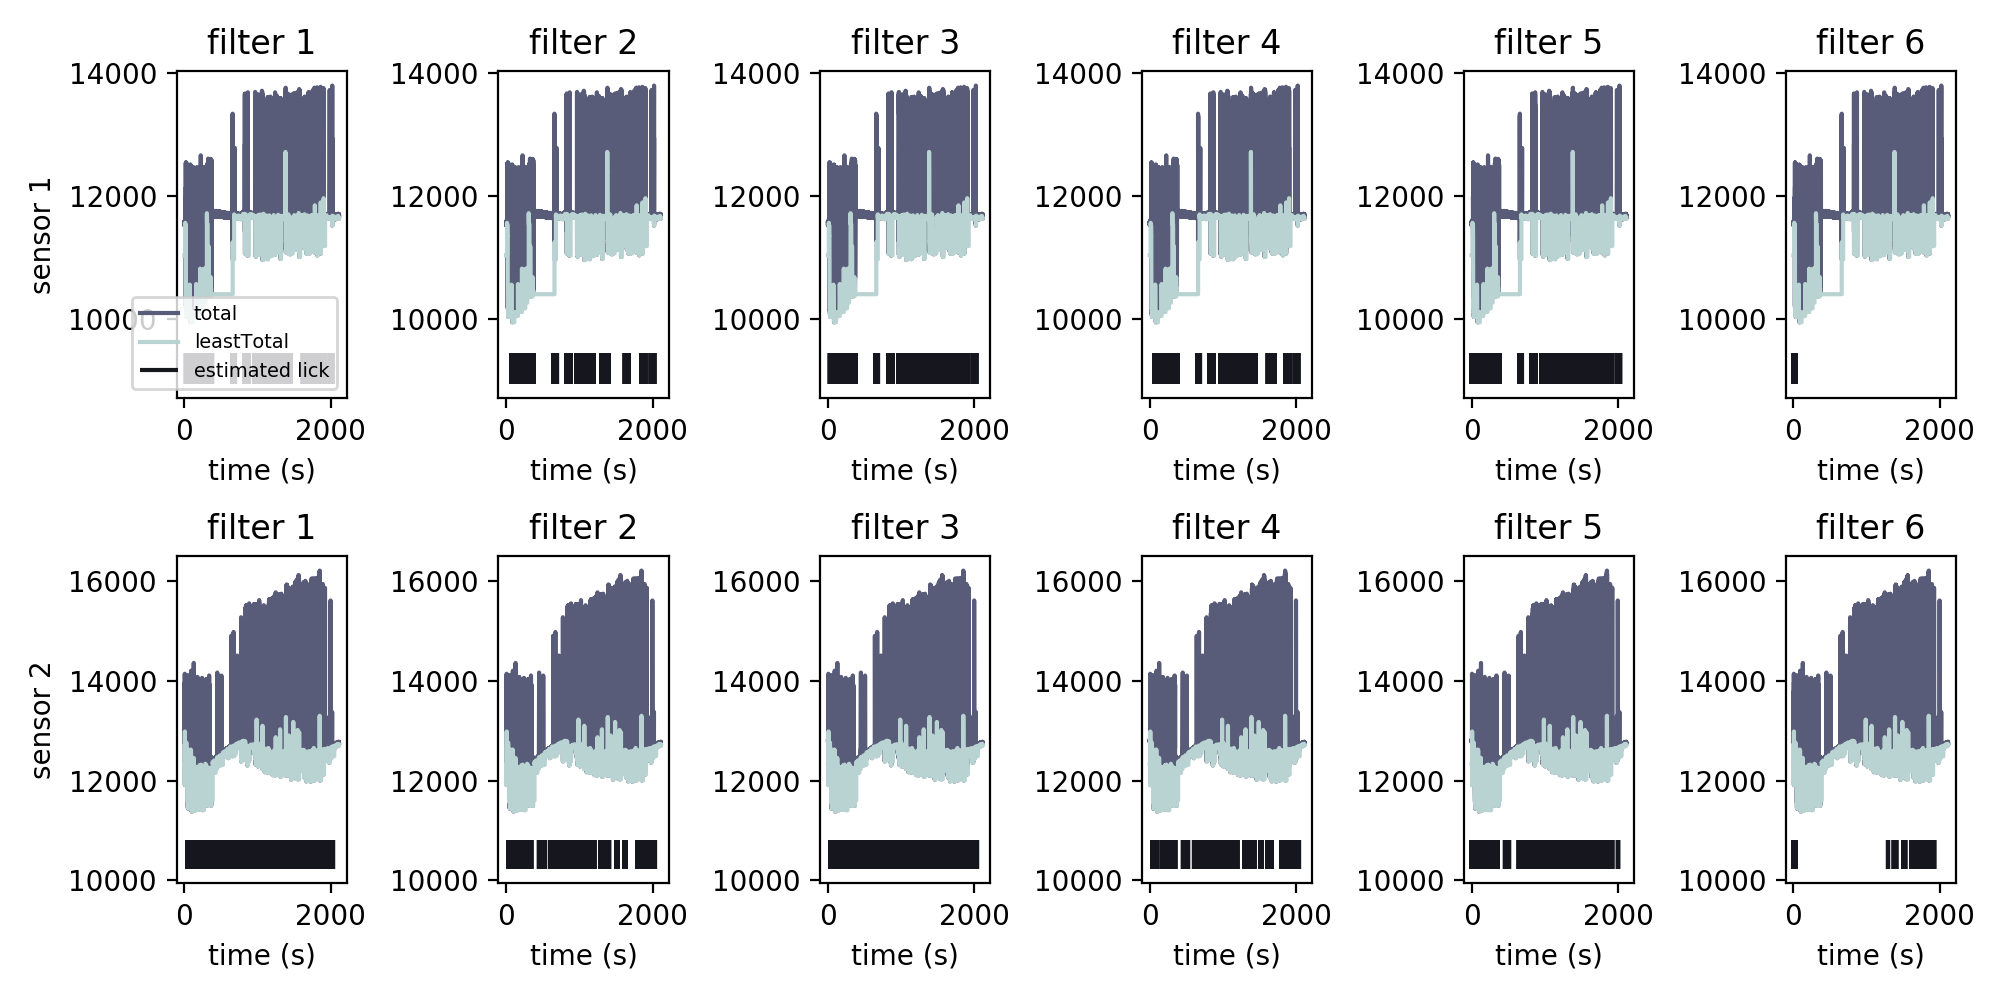

In [5]:
filelist = []
rootname = '../data/filter/W2313_05-20-21_total{}_filt{}.txt'
num_filters = 6
for i in range(len(data)):
    filelist.append([])
    for j in range(num_filters):
        filelist[-1].append(rootname.format(i+1, j+1))

%matplotlib notebook
fig, ax = plt.subplots(nrows=len(data), ncols=num_filters, figsize=(10, 5))

for i, (dat, sublist) in enumerate(zip(data, filelist)):
    ax[i, 0].set_ylabel('sensor {}'.format(i+1))
    
    for j, filename in enumerate(sublist):
    
        sig = np.loadtxt(filename)
        t_sig = t_data[i][np.nonzero(sig)]
        ax_ = ax[i, j]

        # Exclude auto-calibrate samples (leastTotal = MAX_VALUE)
        idx = np.argwhere(dat[:, 3] == 0)

        # Plot values
        ymin = 0.90*dat[idx, 2].min()
        ymax = 0.95*dat[idx, 2].min()
        ax_.plot(t_data[i], dat[:, 1], color=cmap(0.4), label='total') # raw values
        ax_.plot(t_data[i][idx], dat[idx, 2], color=cmap(0.8), label='leastTotal') # original baseline estimate
        ax_.vlines(t_sig, ymin=ymin, ymax=ymax, color=cmap(0.1), label='estimated lick') # estimated lick

        # Format axis
        ax_.set_xlabel('time (s)')
        ax_.set_title('filter {}'.format(j+1))
        
ax[0, 0].legend(loc='lower right', fontsize='x-small');
plt.tight_layout();

Immediate observations:
- The std-threshold filters with a threshold of 5 standard deviations (filters #1, #3) perform poorly, especially with a large shift in baseline (sensor 2), due to many false positives.
- The poor performance of filter #6 is easily corrected by adjusting the threshold manually using the knob on the lick sensor board (e.g. towards filter #5).

Let's zoom in on the best-performing filters: 2, 4, 5.

<IPython.core.display.Javascript object>


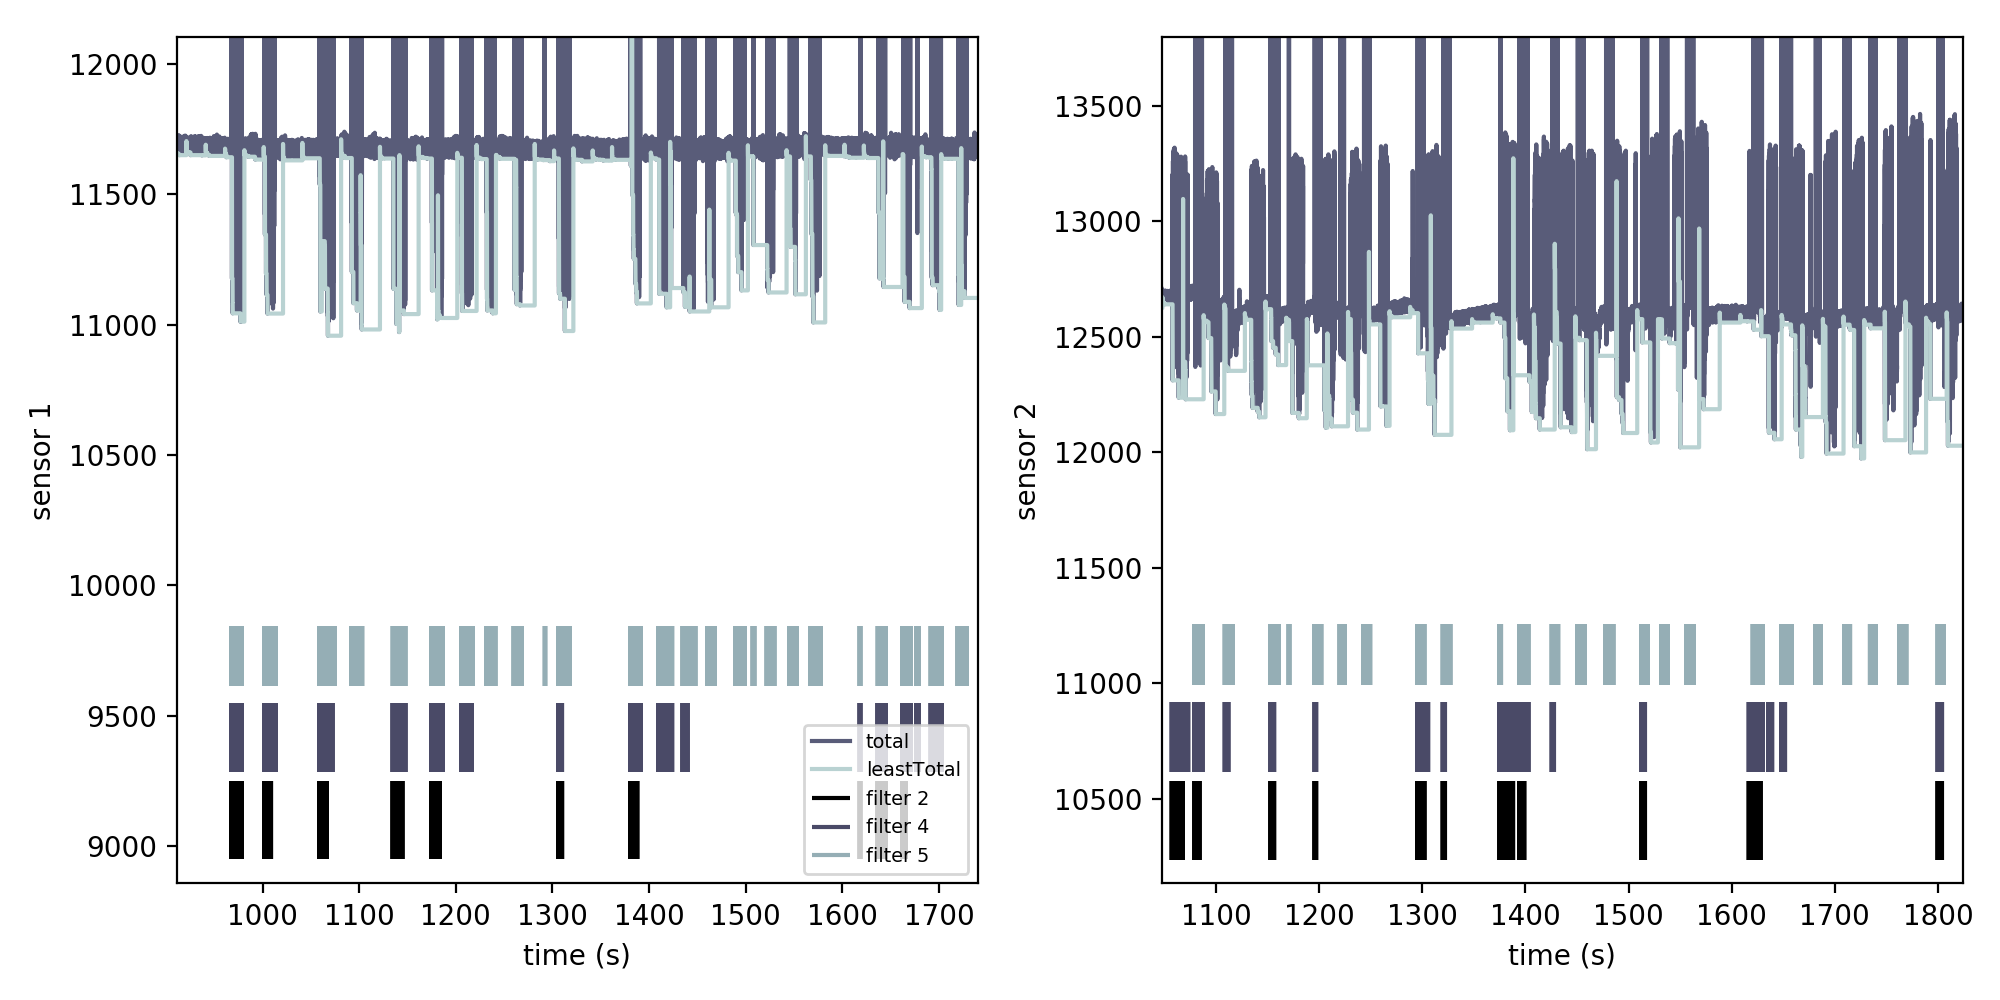

In [13]:
filelist = []
rootname = '../data/filter/W2313_05-20-21_total{}_filt{}.txt'
filter_ids = [2, 4, 5]
for i in range(len(data)):
    filelist.append([])
    for j in filter_ids:
        filelist[-1].append(rootname.format(i+1, j))

%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=len(data), figsize=(10, 5))

for i, (dat, sublist) in enumerate(zip(data, filelist)):
    ax_ = ax[i]
    
    # Exclude auto-calibrate samples (leastTotal = MAX_VALUE)
    idx = np.argwhere(dat[:, 3] == 0)
    
    # Plot raw data
    ax_.plot(t_data[i], dat[:, 1], color=cmap(0.4), label='total') # raw values
    ax_.plot(t_data[i][idx], dat[idx, 2], color=cmap(0.8), label='leastTotal') # original baseline estimate
    
    # Plot filtered data
    for j, (filter_id, filename) in enumerate(zip(filter_ids, sublist)):
        # Load signal
        sig = np.loadtxt(filename)
        t_sig = t_data[i][np.nonzero(sig)]
        
        
        # Plot signal values
        ymin = (0.9 + 0.10*(j/len(filter_ids)))*dat[idx, 2].min()
        ymax = (0.9 + 0.09*((j+1)/len(filter_ids)))*dat[idx, 2].min()
        ax_.vlines(t_sig, ymin=ymin, ymax=ymax, 
                   color=cmap(j/len(filter_ids)), 
                   label='filter {}'.format(filter_id))

    # Format axis
    ax_.set_xlabel('time (s)')
    ax_.set_ylabel('sensor {}'.format(i+1))
        
ax[0].legend(loc='lower right', fontsize='x-small');
plt.tight_layout();

Upon closer inspection, it appears that the std-threshold filters still struggle to strike the proper balance between false positives and false negatives. As discussed above, there must be a balance between incorporating the background of a signal value into the buffer and excluding the actual signal from the buffer. If the background is not incoporated, then the buffer may never capture a baseline shift, leading to many false positives; if the too much of the signal is incorporated, however, then the buffer will overestimate the variance of the background, leading to too many false negatives, as seen here. This is even the case when $\alpha=0.0$ as in filter #4, suggesting that the signal may be too sluggish for this type of filter (i.e. there are too many samples on the upslope or downslope that fall just under the std-threshold and thus are incorporated into the buffer, further increasing its variance).

Overall, the best application for filtering and processing the capacitive sensor signal for lick detection is:
1. Baseline estimated by applying a moving average to downsampled values.
2. Signal estimated by applying a numerical threshold to deviation from the baseline above.

## Appendix

### One-sample update

While the mean and standard deviation of the buffer can be trivially calculated from their definitions:

$
\quad \mu = \frac{1}{N} \sum_n y_n \\
\quad \sigma^2 = \frac{1}{N} \sum_n \left ( y_n - \mu \right )^2
$

this can become expensive with larger buffers (growing $\sim O(N)$). Since the time to update the buffer statistics limits the rate at which the signal can be detected, minimizing calculation time is important. This can be done by updating the current statistics based only on the new sample. Let's say the new sample $x'_j$ replaces the old sample $x_j$ at the $j^{th}$ position in the buffer. The new mean $\mu'$ becomes:

$
\quad \mu  = \frac{1}{N} \left ( \sum_{i \neq j} x_i + x_j  \right ) \\
\quad \mu' = \frac{1}{N} \left ( \sum_{i \neq j} x_i + x'_j \right ) \\
\quad \mu' - \mu = \Delta\mu = \frac{1}{N} \left ( x'_j - x_j \right ) \\
\quad \Rightarrow \mu' = \mu + \frac{1}{N} \left ( x'_j - x_j \right )
$

and the new standard deviation $\sigma'$ becomes:

$
\begin{align}
\quad \sigma^2 = \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu \right )^2 + \left ( x_j - \mu \right )^2 \right ]
\end{align}
$

$
\begin{align}
\quad \sigma'^2 
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu' \right )^2 + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - (\mu + \Delta\mu) \right )^2 + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu - \Delta\mu \right )^2 + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i^2 - 2x_i\mu + \mu^2 \right ) - \sum_{i \neq j} \left ( 2x_i\Delta\mu \right ) + \sum_{i \neq j} \left ( 2\mu\Delta\mu + \Delta\mu^2 \right ) + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu \right )^2 - 2\Delta\mu \sum_{i \neq j} x_i + \left ( N - 1 \right ) \left ( 2\mu\Delta\mu + \Delta\mu^2 \right ) + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \frac{1}{N} \left [ \sum_{i \neq j} \left (x_i - \mu \right )^2 + \left (x_j - \mu \right )^2 - \left (x_j - \mu \right )^2 \right ] + \frac{1}{N} \left [ - 2\Delta\mu \left ( N\mu - x_j \right ) + \left ( N - 1 \right ) \left ( 2\mu\Delta\mu + \Delta\mu^2 \right ) + \left ( x'_j - \mu' \right )^2 \right ] \\
&= \sigma^2 - \frac{1}{N} \left ( x_j - \mu \right )^2 + \frac{1}{N} \left ( x'_j - \mu' \right )^2 + \frac{1}{N} \left [ - 2N\mu\Delta\mu + 2\Delta\mu x_j + 2N\mu\Delta\mu + N\Delta\mu^2 - 2\mu\Delta\mu - \Delta\mu^2 \right ] \\
&= \sigma^2 - \frac{1}{N} \left ( x_j - \mu \right )^2 + \frac{1}{N} \left ( x'_j - \mu' \right )^2 + \frac{1}{N} \left [ 2\Delta\mu \left ( x_j - \mu \right ) + \left ( N - 1 \right ) \Delta\mu^2 \right ] \\
&= \sigma^2 - \frac{1}{N} \left ( x_j - \mu \right )^2 + \frac{1}{N} \left ( x'_j - \mu' \right )^2 + \frac{2\Delta\mu}{N} \left ( x_j - \mu \right ) + \frac{N - 1}{N} \Delta\mu^2
\end{align}
$

which grows with constant time. Note that some drift may occur due to rounding errors over time, which can be corrected by occassionally calculating the mean and standard deviation over the entire buffer.

### Off-time responsiveness

#### Off-time parameter relationship
Here, we will assume that $\sigma' = 0$ for simplicity. Let's work backwards from time $t$ (we will write $(1 - \alpha) = \beta$ for readability):

$
\begin{align}
\quad x_t 
&= \alpha y' + \beta x_{t-1} \\
&= \alpha y' + \beta (\alpha y' + \beta x_{t-2}) \\
&= \alpha y' + \alpha \beta y' + \beta^2 x_{t-2} \\
&= \alpha y' + \alpha \beta y' + \beta^2 (\alpha y' + \beta x_{t-3}) \\
&= \alpha y' + \alpha \beta y' + \alpha \beta^2 y' + \beta^3 x_{t-3} \\
& \vdots \\
&= \sum_{i = 0}^{t-1} \alpha \beta^i y' + \beta^t y_0 \\
&= \alpha y' \sum_{i = 0}^{t-1} \beta^i + \beta^t y \quad (\text{since } y_0 = y) \\
&= \alpha \left ( y + k \right ) \sum_{i = 0}^{t-1} \beta^i + \beta^t y \\
&= \alpha y \sum_{i = 0}^{t-1} \beta^i + \beta^t y + \alpha k \sum_{i = 0}^{t-1} \beta^i \\
&= y \left ( \alpha \sum_{i = 0}^{t-1} \beta^i + \beta^t \right ) + \alpha k \sum_{i = 0}^{t-1} \beta^i \\
&= y + \alpha k \sum_{i = 0}^{t-1} \beta^i \quad (\text{since } \alpha \sum_{i = 0}^{t-1} \beta^i + \beta^t = 1) \\
&= y + k \left ( 1 - \beta^t \right ) \quad (\text{for same reason as above})
\end{align}
$

With a buffer of size $n$, the mean and standard deviation at time $t$ is:

$
\begin{align}
\quad \mu_t
&= \frac{1}{n} \sum_{i=t-n+1}^{t} x_i \\
&= \frac{1}{n} \sum_{i=t-n+1}^{t} \left [ y + k \left ( 1 - \beta^i \right ) \right ] \\
&= \frac{1}{n} \sum_{i=t-n+1}^{t} y + \frac{k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) \\
&= y + \frac{k}{n} \left ( n - \sum_{i=t-n+1}^{t} \beta^i \right ) \\
&= y + k - \frac{k}{n} \sum_{i=t-n+1}^{t} \beta^i
\end{align}
$

$
\begin{align}
\quad \sigma^2_t
&= \mathbb{E}_t[X^2] - \mathbb{E}_t[X]^2 \\
&= \frac{1}{n} \sum_{i=t-n+1}^{t} \left ( x_i^2 \right ) - \mu_t^2 \\
&= \frac{1}{n} \sum_{i=t-n+1}^{t} \left ( y + k \left ( 1 - \beta^i \right ) \right )^2 - \left ( y + \frac{k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) \right )^2 \\
&= \frac{1}{n} \sum_{i=t-n+1}^{t} \left ( y^2 + 2 y k \left ( 1 - \beta^i \right ) + k^2 \left  (1 - \beta^i \right )^2 \right ) - \left ( y^2 + + \dfrac{2 y k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) + \left ( \frac{k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) \right )^2 \right ) \\
&= \dfrac{1}{n} \sum_{i=t-n+1}^{t} y^2 + \dfrac{2 y k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) + \dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right )^2 \right ) \\ &\quad - y^2 - \dfrac{2 y k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) - \frac{k^2}{n^2} \left ( n - \sum_{i=t-n+1}^{t} \beta^i \right )^2 \\
&= y^2 - y^2 + \dfrac{2 y k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) - \dfrac{2 y k}{n} \sum_{i=t-n+1}^{t} \left ( 1 - \beta^i \right ) \\ &\quad + \dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \left ( 1 - 2 \beta^i + \beta^{2i} \right ) \right ) - \dfrac{k^2}{n^2} \left ( n^2 - 2 n \sum_{i=t-n+1}^{t} \beta^i + \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2  \right ) \\
&= \dfrac{k^2}{n} \left (  n - 2 \sum_{i=t-n+1}^{t} \beta^i + \sum_{i=t-n+1}^{t} \beta^{2i} \right ) - \dfrac{k^2}{n^2} \left ( n^2 - 2 n \sum_{i=t-n+1}^{t} \beta^i + \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2  \right ) \\
&= k^2 - \dfrac{2 k^2}{n} \sum_{i=t-n+1}^{t} \beta^i + \dfrac{k^2}{n} \sum_{i=t-n+1}^{t} \beta^{2i} - k^2 + \dfrac{2 k^2}{n} \sum_{i=t-n+1}^{t} \beta^i - \dfrac{k^2}{n^2} \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2 \\
&= \dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \beta^{2i} - \dfrac{1}{n} \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2 \right )
\end{align}
$

The time $t^*$ at which the new baseline is set occurs when the condition $y'_t - \mu_t \leq \gamma \sigma_t$ is met:

$
\begin{align}
\quad y' 
&\leq \mu_t + \gamma \sigma_t \\
\Rightarrow y + k 
&\leq y + k - \frac{k}{n} \sum_{i=t-n+1}^{t} \beta^i + \gamma \sqrt{\dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \beta^{2i} - \dfrac{1}{n} \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2 \right )} \\
\Rightarrow 0 
&\leq - \frac{k}{n} \sum_{i=t-n+1}^{t} \beta^i + \gamma \sqrt{\dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \beta^{2i} - \dfrac{1}{n} \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2 \right )}
\end{align}
$

For a given datastream $y$, $k$ and buffer parameter $\alpha$, we have three variables–$n$, $t$, and $\gamma$–whose relationship is defined by the equation above. Let's examine each of the three variables:

$
\begin{align}
\quad \gamma 
&\geq \dfrac{\dfrac{k}{n} \sum_{i=t-n+1}^{t} \beta^i}{ \sqrt{\dfrac{k^2}{n} \left ( \sum_{i=t-n+1}^{t} \beta^{2i} - \dfrac{1}{n} \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2 \right )}} \\
&\geq \dfrac{\dfrac{k}{n} \sum_{i=t-n+1}^{t} \beta^i}{ \dfrac{k}{n}\sqrt{n \sum_{i=t-n+1}^{t} \beta^{2i} - \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}} \\
&\geq \dfrac{\sum_{i=t-n+1}^{t} \beta^i}{\sqrt{n \sum_{i=t-n+1}^{t} \beta^{2i} - \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}} \\
&\geq \sqrt{ \dfrac{\left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}{n \sum_{i=t-n+1}^{t} \beta^{2i} - \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}}
\end{align}
$

If we rewrite the summations using the identity $\sum_{i=j}^{k} \beta^{mi} = \frac{\beta^{k+1} - \beta^j}{\beta^m - 1}$:

$
\begin{align}
\quad \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2
&= \left ( \dfrac{\beta^{t+1} - \beta^{t-n+1}}{\beta - 1} \right )^2 \\
&= \dfrac{\beta^{2t} \left ( \beta - \beta^{1-n} \right )^2}{\left ( \beta - 1 \right )^2}
\end{align}
$

$
\begin{align}
\quad \sum_{i=t-n+1}^{t} \beta^{2i}
&= \dfrac{\beta^{2(t+1)} - \beta^{2(t-n+1)}}{\beta^2 - 1} \\
&= \dfrac{\beta^{2t} \left ( \beta^2 - \beta^{2n - 2} \right )}{\left ( \beta + 1 \right ) \left ( \beta - 1 \right )}
\end{align}
$

We arrive at the following equivalent expression for $\gamma$:

$
\begin{align}
\quad \gamma
&\geq \sqrt{ \dfrac{\left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}{n \sum_{i=t-n+1}^{t} \beta^{2i} - \left ( \sum_{i=t-n+1}^{t} \beta^i \right )^2}} \\
&\geq \sqrt{\dfrac{\dfrac{\beta^{2t} \left ( \beta - \beta^{1-n} \right )^2}{\left ( \beta - 1 \right )^2}}{n \dfrac{\beta^{2t} \left ( \beta^2 - \beta^{2n - 2} \right )}{\left ( \beta + 1 \right ) \left ( \beta - 1 \right )} - \dfrac{\beta^{2t} \left ( \beta - \beta^{1-n} \right )^2}{\left ( \beta - 1 \right )^2}} \cdot \dfrac{\left ( \beta - 1 \right )^2 \left ( \beta + 1 \right )}{\left ( \beta - 1 \right )^2 \left ( \beta + 1 \right )}} \\
&\geq \sqrt{\dfrac{\beta^2 \left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{\beta^2 \left ( n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right ) \right )}} \\
&\geq \sqrt{\dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )}}
\end{align}
$

Interestingly, the equation is entirely defined by $\alpha$, $n$, and $\gamma$; in other words, the off-time is independent of the data stream ($y$ or $k$) and the actual time after the baseline shift ($t$). The independence from data is 1) convenient because we don't have to tailor our parameters to particular baselines or baseline shifts, and 2) intuitive because as $k$ grows, so do both $y'_t - \mu_t$ and $\gamma \sigma_t$. The independence from time is puzzling at first, since we can no longer solve for the time at which the baseline shift will be detected. However, as is clear from the plots below, this is because the solution for $t$ is all or nothing: either the condition $y'_t - \mu_t \leq \gamma \sigma_t$ is satisfied for all $t$ (after one buffer run-through) or never. Lastly, we can rearrange the above equation to more conveniently solve for $n$:

$
\begin{align}
\quad &\gamma
\geq \sqrt{\dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )}} \\
\quad &\Rightarrow \gamma^2
\geq \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )} \\
\quad &\Rightarrow \gamma^2 - \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )} \geq 0
\end{align}
$

Thus to find the bounds of parameter space that ensures detection, we must find the zeros of the equation:

$
f(\beta, \gamma, n) = \gamma^2 - \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left ( \beta - 1 \right ) \left (1 - \beta^{-2n} \right ) - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )}
$

#### Proof that summation is equal to one

Here's a funny aside. I initially had forgotten the old value in the summation term, leading to the equation:

$
\quad x_t = y' \left ( \alpha \sum_{j = 0}^{i-1} \beta^j + \beta^i \right ) \\
\quad \sigma_t^2 = \frac{y'^2}{n^2} \left [ \sum_{i=t-n+1}^{t} \left ( \alpha \sum_{j = 0}^{i-1} \beta^j + \beta^i \right )^2 - \left ( \sum_{i=t-n+1}^{t} \left ( \alpha \sum_{j = 0}^{i-1} \beta^j + \beta^i \right ) \right )^2 \right ]
$

But, of course, if all terms in the buffer were $y'$ to begin, then the buffer should never change: $x_t = y', \sigma_t^2 = 0 \quad \forall t$. And this is what happens! As it turns out, $\alpha \sum_{j = 0}^{i-1} \beta^j + \beta^i = 1$, where $\beta = (1 - \alpha)$. Let's prove this:

$
\begin{align}
\quad S(i-1) 
&= \alpha \sum_{j = 0}^{i-2} (1 - \alpha)^j + (1 - \alpha)^{i-1} \\
&= \alpha \sum_{j = 0}^{i-1} (1 - \alpha)^j - \alpha (1 - \alpha)^{i-1} + (1 - \alpha)^{i-1} \\
&= \alpha \sum_{j = 0}^{i-1} (1 - \alpha)^j + (1 - \alpha) (1 - \alpha)^{i-1} \\
&= \alpha \sum_{j = 0}^{i-1} (1 - \alpha)^j + (1 - \alpha)^{i} \\
&= S(i)
\end{align}
$

$
\quad \Rightarrow S(i) = S(i-1) = \cdots = S(0) = 1
$

#### Proof that equation is even
The equation for solving for the filter parameters is even, meaning that $f(n) = f(-n)$. Let's make use of the following equations:

$
\left ( 1 - \beta^{n} \right )^2 = \left ( \beta^{-n} - 1 \right )^2 = \left ( 1 - \beta^{-n} \right )^2 \\
\left (1 - \beta^{2n} \right ) = \left (\beta^{-2n} - 1 \right )
$

where we multiplied each term in the initial expressions by $\beta^{-n}$ and $\beta^{-2n}$, respectively. We can then prove that the equation is even by substituting $-n$ for $n$:

$
\begin{align}
f(-n)
&= \gamma^2 - \dfrac{\left ( 1 - \beta^{-(-n)} \right )^2 \left (\beta + 1 \right )}{(-n) \left (1 - \beta^{-2(-n)} \right ) \left ( \beta - 1 \right ) - \left ( 1 - \beta^{-(-n)} \right )^2 \left ( \beta + 1 \right )} \\
&= \gamma^2 - \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{(-n) \left (\beta^{-2n} - 1 \right ) \left ( \beta - 1 \right )  - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )} \\
&= \gamma^2 - \dfrac{\left ( 1 - \beta^{-n} \right )^2 \left (\beta + 1 \right )}{n \left (1 - \beta^{-2n} \right ) \left ( \beta - 1 \right )  - \left ( 1 - \beta^{-n} \right )^2 \left ( \beta + 1 \right )} \\
&= f(n)
\end{align}
$

As we can see from the plot below, the equation is even with respect to $n$. Thus non-linear solvers can obtain either the positive or negative solution when attempting to find $n$ given $\alpha$, $\gamma$. Moreover, it is clear that $\lim_{|n| \to 1} f(n) = +\infty$ and $\lim_{|n| \to \infty} f(n) = 0$.

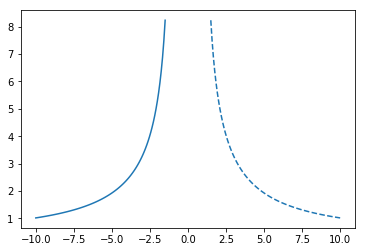

In [402]:
# Plot f(-n) and f(n)
n = np.linspace(1.5, 10, 100)
plt.plot(-n, get_off_time(alpha, n=-n), color='C0')
plt.plot(n, get_off_time(alpha, n=n), color='C0', linestyle='--');

This also holds true for $\beta = 1.0 - \alpha$ if $n = 2m$ is even, since $(-\beta)^{2m} = ((-\beta)^2)^m = (\beta^2)^m = \beta^{2m}$. However, it does not hold for odd (or non-integer) values of $n$.